<a href="https://colab.research.google.com/github/HeorhiiY/cv-course/blob/main/project/Project_data_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Display

import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def plot_image_with_bboxes(image_path, label_path):
    """
    Display an image with bounding boxes drawn based on YOLO labels.

    Args:
    - image_path (str): Path to the image file.
    - label_path (str): Path to the YOLO label file corresponding to the image.
    """
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Get image dimensions
    height, width, _ = image.shape

    # Read YOLO label file
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # Draw bounding boxes
    for label in labels:
        parts = label.strip().split()
        class_id, x_center, y_center, box_width, box_height = map(float, parts)

        # Denormalize the coordinates
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height

        # Calculate top-left and bottom-right corners
        x_min = int(x_center - box_width / 2)
        y_min = int(y_center - box_height / 2)
        x_max = int(x_center + box_width / 2)
        y_max = int(y_center + box_height / 2)

        # Draw the bounding box
        color = (255, 0, 0)  # Red color for bounding boxes
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, f'Class {int(class_id)}', (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(10, 6), dpi=600)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
image_folder = Path("/content/drive/MyDrive/Colab Notebooks/project/data/train_images")
label_folder = Path("/content/drive/MyDrive/Colab Notebooks/project/data/labels/train")

# Get all image and label files
images = sorted(image_folder.glob("*.tif"))
labels = sorted(label_folder.glob("*.txt"))

# Display the first 5 images with bounding boxes
for img_path, lbl_path in zip(images[:5], labels[:5]):
    print(f"Displaying: {img_path.name}")
    plot_image_with_bboxes(img_path, lbl_path)

# saved on Github without output (too big pictures)

In [1]:
import json
import pandas as pd
from tqdm import tqdm

xview_class2index = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 2, -1, 3, -1, 4, 5, 6, 7, 8, -1, 9, 10, 11,
                          12, 13, 14, 15, -1, -1, 16, 17, 18, 19, 20, 21, 22, -1, 23, 24, 25, -1, 26, 27, -1, 28, -1,
                          29, 30, 31, 32, 33, 34, 35, 36, 37, -1, 38, 39, 40, 41, 42, 43, 44, 45, -1, -1, -1, -1, 46,
                          47, 48, 49, -1, 50, 51, -1, 52, -1, -1, -1, 53, 54, -1, 55, -1, -1, 56, -1, 57, -1, 58, 59]

labels_dict = {
    0: "Fixed-wing Aircraft",
    1: "Small Aircraft",
    2: "Cargo Plane",
    3: "Helicopter",
    4: "Passenger Vehicle",
    5: "Small Car",
    6: "Bus",
    7: "Pickup Truck",
    8: "Utility Truck",
    9: "Truck",
    10: "Cargo Truck",
    11: "Truck w/Box",
    12: "Truck Tractor",
    13: "Trailer",
    14: "Truck w/Flatbed",
    15: "Truck w/Liquid",
    16: "Crane Truck",
    17: "Railway Vehicle",
    18: "Passenger Car",
    19: "Cargo Car",
    20: "Flat Car",
    21: "Tank car",
    22: "Locomotive",
    23: "Maritime Vessel",
    24: "Motorboat",
    25: "Sailboat",
    26: "Tugboat",
    27: "Barge",
    28: "Fishing Vessel",
    29: "Ferry",
    30: "Yacht",
    31: "Container Ship",
    32: "Oil Tanker",
    33: "Engineering Vehicle",
    34: "Tower crane",
    35: "Container Crane",
    36: "Reach Stacker",
    37: "Straddle Carrier",
    38: "Mobile Crane",
    39: "Dump Truck",
    40: "Haul Truck",
    41: "Scraper/Tractor",
    42: "Front loader/Bulldozer",
    43: "Excavator",
    44: "Cement Mixer",
    45: "Ground Grader",
    46: "Hut/Tent",
    47: "Shed",
    48: "Building",
    49: "Aircraft Hangar",
    50: "Damaged Building",
    51: "Facility",
    52: "Construction Site",
    53: "Vehicle Lot",
    54: "Helipad",
    55: "Storage Tank",
    56: "Shipping container lot",
    57: "Shipping Container",
    58: "Pylon",
    59: "Tower"
}


parent_labels_dict = {
    -1: "None",
    0: "Fixed-wing Aircraft",
    1: "Passenger Vehicle",
    2: "Truck",
    3: "Railway Vehicle",
    4: "Maritime Vessel",
    5: "Engineering Vehicle",
    6: "Building"
}

def convert_child_to_parent(child_class):
  if 52 < child_class < 59 or child_class == 3:
    return -1
  elif child_class < 3:
    return 0
  elif child_class < 6:
    return 1
  elif child_class < 17:
    return 2
  elif child_class < 23:
    return 3
  elif child_class < 33:
    return 4
  elif child_class < 48:
    return 5
  else:
    return 6

# Load GeoJSON file
geojson_file_path = '/content/drive/MyDrive/Colab Notebooks/project/data/xView_train.geojson'
with open(geojson_file_path, 'r') as f:
    geojson_data = json.load(f)

# Extract features
features = geojson_data['features']

# Convert features to a DataFrame
data = []
for feature in tqdm(features):
    properties = feature['properties']
    class_id = xview_class2index[properties['type_id']]
    if class_id == -1:
      print(f"Invalid type_id{properties['type_id']}, skipped")
    data.append({
        'image_id': properties['image_id'],
        'class_id': class_id,
        'bounds_imcoords': properties['bounds_imcoords'],
        "parent_class_id": convert_child_to_parent(class_id)
    })

df = pd.DataFrame(data)

# Show the first few rows
print(df.head())

 10%|█         | 62908/601937 [00:00<00:01, 316052.31it/s]

Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id82, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped


 26%|██▌       | 157398/601937 [00:00<00:01, 298051.78it/s]

Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped


 36%|███▋      | 219153/601937 [00:00<00:01, 303722.85it/s]

Invalid type_id82, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id75, skipped
Invalid type_id82, skipped


 59%|█████▊    | 353634/601937 [00:01<00:00, 329928.40it/s]

Invalid type_id82, skipped
Invalid type_id82, skipped


 80%|████████  | 482344/601937 [00:01<00:00, 304320.77it/s]

Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id75, skipped
Invalid type_id75, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped


100%|██████████| 601937/601937 [00:01<00:00, 331913.42it/s]

Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id82, skipped
Invalid type_id75, skipped
Invalid type_id82, skipped
Invalid type_id75, skipped


   image_id  class_id      bounds_imcoords  parent_class_id
0  2355.tif        48  2712,1145,2746,1177                6
1  2355.tif        48  2720,2233,2760,2288                6
2  2355.tif        48  2687,1338,2740,1399                6
3  2355.tif        48  2691,1201,2730,1268                6
4  2355.tif        48    2671,838,2714,869                6


In [2]:
print(df.memory_usage())


Index                  128
image_id           4815496
class_id           4815496
bounds_imcoords    4815496
parent_class_id    4815496
dtype: int64


In [3]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/project/data/df.csv', index=False)

In [4]:
print(len(df))

601937


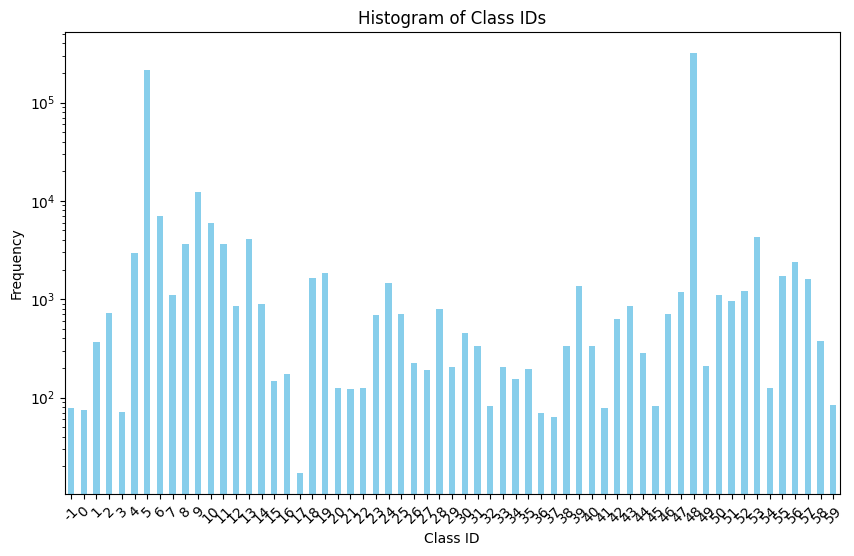

In [6]:
import matplotlib.pyplot as plt

# Plotting the histogram for `class_id`
plt.figure(figsize=(10, 6))
df['class_id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.yscale('log')
plt.title('Histogram of Class IDs')
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

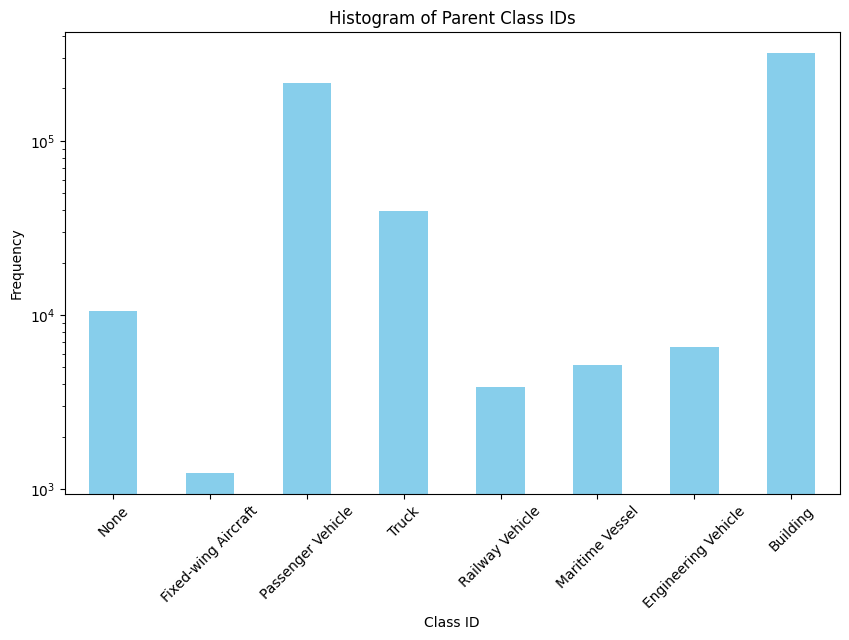

In [14]:
import matplotlib.pyplot as plt

# Plotting the histogram for `parent_class_id`
plt.figure(figsize=(10, 6))
ax = df['parent_class_id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
# Set the x-ticks to the labels from your dictionary
ax.set_xticks(range(len(parent_labels_dict)))
# ax.set_xticks(current_ticks)  # Ensure ticks are set at the correct positions
# print(current_ticks)
ax.set_xticklabels([parent_labels_dict.get(key) for key in parent_labels_dict], rotation=45)
plt.yscale('log')
plt.title('Histogram of Parent Class IDs')
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()